In [1]:
import sys
sys.path.append('../')
from time import sleep
from models.attention_series import Grade_regressor
import spectral
from configs.training_cfg import device
import torch
import ast
import numpy as np
from PIL import Image
from spectral import imshow
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt

spectral.settings.envi_support_nonlowercase_params = True

In [2]:
mask_rgb_values = [[255,242,0],[34,177,76],[255,0,88]]

spec_id = 55    # 选择评估的成像光谱图片编号

pool = torch.nn.AvgPool2d(3,3)
img = spectral.envi.open("E:\\d盘备份\\近红外部分\\spectral_data\\{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(spec_id))

# 根据模型使用波段选择
# img_data = torch.Tensor(img.asarray()/6000)[:,:,:-4]
img_data = torch.Tensor(img.asarray()/6000)[:,:,:]
# img_data = pool(img_data.permute(1,2,0)).permute(2,0,1)
mask = np.array(Image.open("E:\\d盘备份\\近红外部分\\spectral_data\\{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr_mask.png".format(spec_id)))
gt_TFe = ast.literal_eval(img.metadata['gt_TFe'])

In [3]:
# 再此处指定模型

# model = feature_conbined_regression(freeze=False).to(device).eval()
model = Grade_regressor().to(device).eval()
model.load_state_dict(torch.load("..\\ckpt\\(NIR)RELU+ALLINDEX_LINEAR_70000.pt"))

<All keys matched successfully>

In [4]:
img_data.shape

torch.Size([528, 320, 168])

In [5]:
with torch.no_grad():
    img_data = pool(img_data.permute(2,0,1)).permute(1,2,0)

In [6]:
img_data.shape

torch.Size([176, 106, 168])

In [7]:
row,col,_ = img_data.shape

In [8]:
# 获得像素级反演结果

with torch.no_grad():

    heat_map = []

    for i in range(row):
        heat_map.append(model(img_data[i].to(device)).squeeze(1).unsqueeze(0).to("cpu"))
        torch.cuda.empty_cache()
        if (i+1)%50 == 0:
            print("\r已生成{}行结果".format(i+1), end="")

    # heat_map = torch.clamp(torch.cat(heat_map, dim=0),0,1)

已生成150行结果

In [9]:
heat_map = torch.cat(heat_map, dim=0)

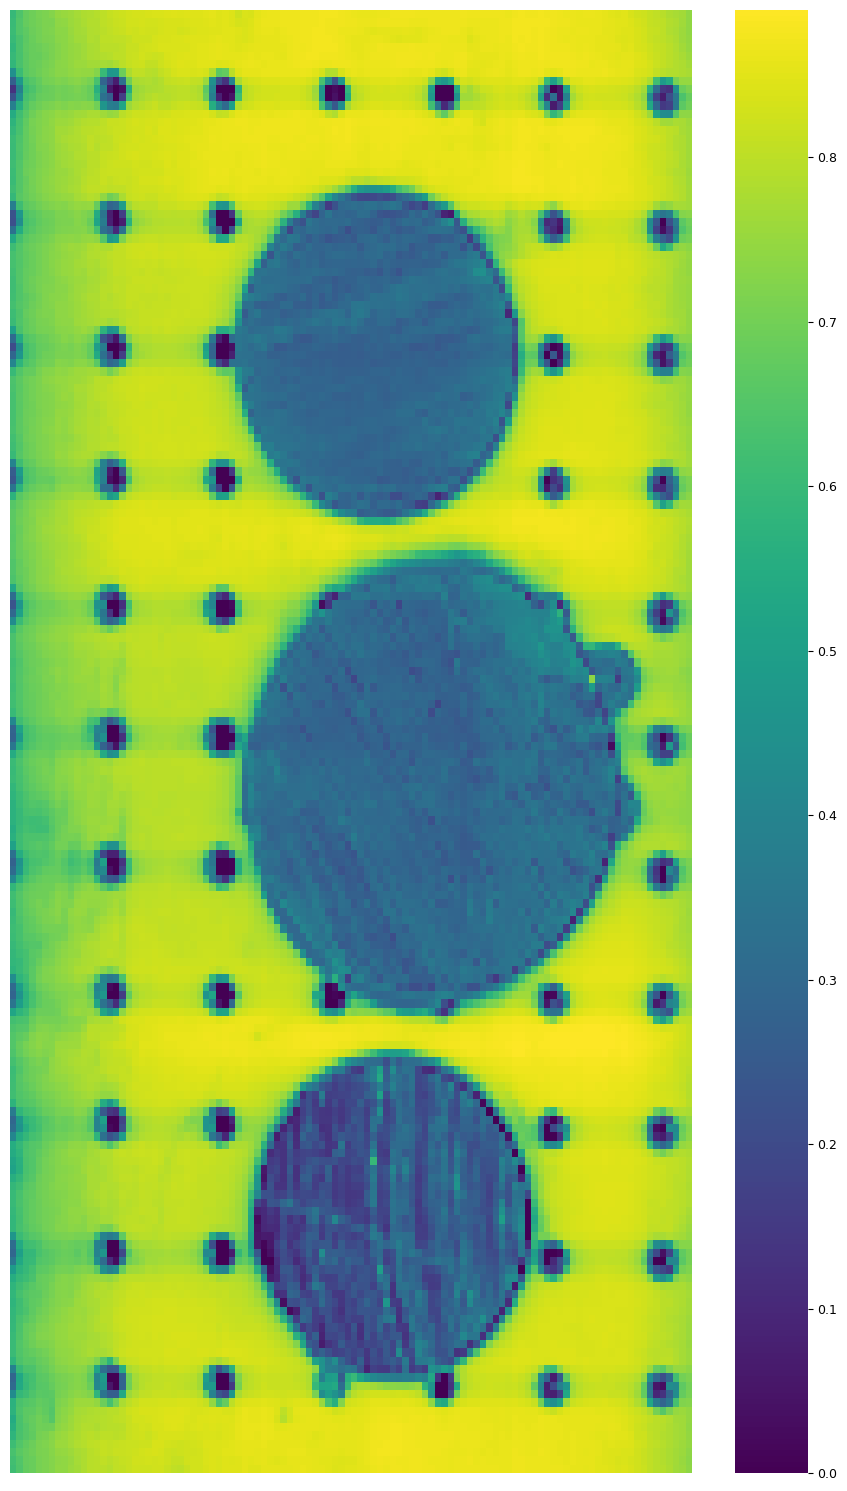

In [10]:
# 绘制并保存像素级反演热图
import seaborn as sns
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11,19

hm = sns.heatmap(heat_map.numpy(), cmap="viridis", xticklabels=False, yticklabels=False)
hm.figure.savefig("{}号预测结果可视化.jpg".format(spec_id))

ImageView object:
  Display bands       :  [0, 84, 167]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.1885, 0.8831]
    G: [0.0288, 0.6191]
    B: [0.0598, 0.4279]

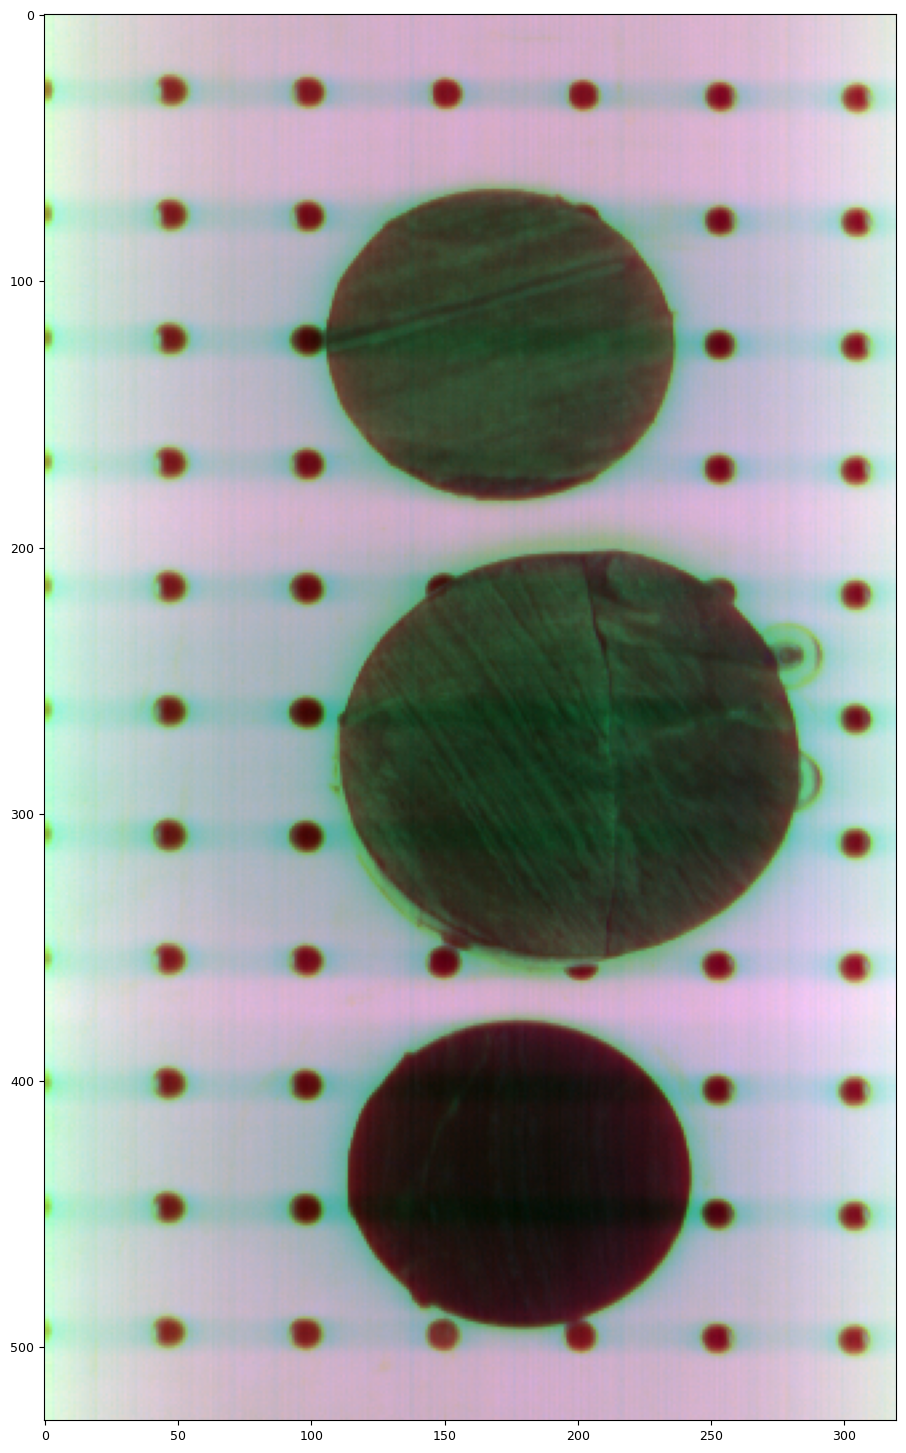

In [11]:
imshow(img)

In [12]:
predict_sum = torch.Tensor([0.,0.,0.])
pixel_count = torch.Tensor([0, 0, 0])
gt = torch.Tensor(gt_TFe)

values = [[],[],[]] # 分析数据分布

if mask.shape[2] == 4:
    mask = mask[:,:,:-1]

for r in range(row):
    for c in range(col):
        for i in range(3):
            if mask[r*3+1,c*3+1].tolist() == mask_rgb_values[i]:
                predict_sum[i] += heat_map[r,c] 
                values[i].append(heat_map[r,c])    # 分析数据分布
                pixel_count[i] += 1

prediction = predict_sum / pixel_count * 100

print("预测值:{}".format(str(prediction.tolist())))
print("真值:{}".format(str(gt_TFe)))
print("绝对误差:{}".format(str((prediction-gt).tolist())))
print("相对误差:{}".format(str(((prediction-gt)/gt).tolist())))
                

预测值:[29.9764404296875, 30.76116371154785, 23.89077377319336]
真值:[28.7, 28.88, 16.77]
绝对误差:[1.2764396667480469, 1.88116455078125, 7.1207733154296875]
相对误差:[0.0444752499461174, 0.06513728201389313, 0.4246137738227844]


In [13]:
# predict_sum = torch.Tensor([0.,0.,0.])
# pixel_count = torch.Tensor([0, 0, 0])
# gt = torch.Tensor(gt_TFe)

# values = [[],[],[]] # 分析数据分布

# for r in range(row):
#     for c in range(col):
#         for i in range(3):
#             if mask[r,c][:-1].tolist() == mask_rgb_values[i]:
#                 predict_sum[i] += heat_map[r,c] 
#                 values[i].append(heat_map[r,c])    # 分析数据分布
#                 pixel_count[i] += 1

# prediction = predict_sum / pixel_count * 100

# print("预测值:{}".format(str(prediction.tolist())))
# print("真值:{}".format(str(gt_TFe)))
# print("绝对误差:{}".format(str((prediction-gt).tolist())))
# print("相对误差:{}".format(str(((prediction-gt)/gt).tolist())))

In [20]:
sns.displot(np.array(values[0]))

ValueError: If using all scalar values, you must pass an index

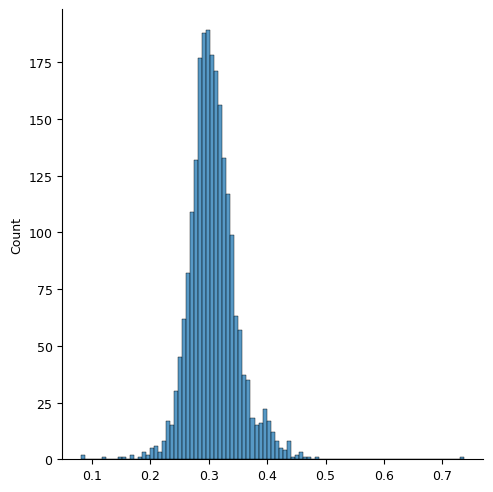

In [19]:
sns.displot(np.array(values[1]))

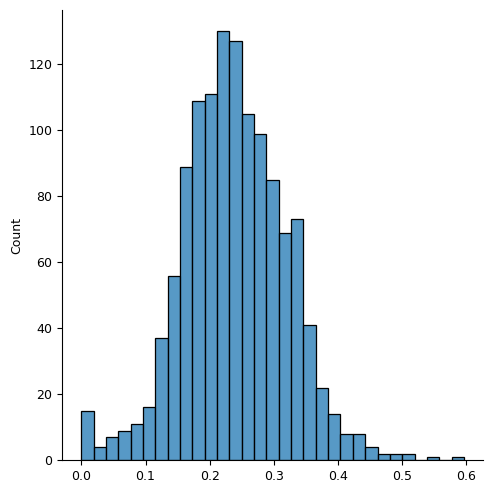

In [16]:
sns.displot(np.array(values[2]))

In [17]:
np.array(values[1]).var()

0.0016909174

In [18]:
np.array(values[1]).mean()

0.3076119